# K Nearest Neighbors
* https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/
* https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4978658/

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import time
import pickle
from collections import defaultdict 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Nos modules
import knn
import params_tuning as pt
import randomforest as rf

## 1. Importation des données

In [35]:
data = pd.read_csv("data.csv")

In [36]:
print(data.shape)
data.head()

(1000, 32)


,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,spectral_contrast,spectral_flatness,tonnetz,estimated_tempo,genre/label
0,country.00094,0.366838,0.206715,1474.849928,1745.839794,3108.264538,0.062993,-104.34503,136.39078,-20.945368,...,2.197093,-7.109390,1.849674,1.675598,-1.492039,23.567712,0.001825,0.026578,112.347147,country
1,country.00025,0.347253,0.079920,1565.431223,2016.069774,3188.930717,0.057303,-200.55273,119.67490,-3.610737,...,-11.293138,-8.870809,-8.073557,-3.161044,0.330751,19.845071,0.008667,0.018447,143.554688,country
2,country.00076,0.297332,0.128385,1321.679067,1409.586676,2590.392670,0.066525,-183.93301,159.80644,-23.158834,...,-3.583324,-9.062474,-3.159365,-4.068544,-7.052489,23.526738,0.001220,-0.013900,143.554688,country
3,country.00030,0.221390,0.079631,1240.515214,1996.754074,2412.635411,0.042844,-277.08127,128.25803,42.433240,...,1.391878,3.080010,2.513260,-1.051766,-2.753359,22.093318,0.002381,-0.009946,161.499023,country
4,country.00089,0.322114,0.104638,1321.678546,1667.211777,2583.926042,0.052503,-205.12328,140.99438,-8.959963,...,3.140506,-4.527332,2.654261,-3.122376,-10.710899,24.189410,0.001850,0.002900,143.554688,country


In [37]:
# On supprime la premiere colonne
data = data.drop(['filename'],axis=1)

# On change les noms des genres par des entiers (de 0 a 9) car notre random forest ne prend en compte que des entiers comme labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
labels = encoder.fit_transform(genre_list)
data.iloc[:, -1] = labels

In [38]:
# On normalise le dataset
scaler = StandardScaler()
data_normalized = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## 2. Apprentissage du modèle de base

In [39]:
# On separe le dataset en train set et test set (80%/20%)
data_train, data_test, label_train, label_test = train_test_split(data_normalized, labels, test_size=0.2)
n_samples, n_features = data_train.shape
print("data_train {0} | label_train {1}".format(data_train.shape, label_train.shape))
print("data_test  {0} | label_test  {1}".format(data_test.shape, label_test.shape))

data_train (800, 30) | label_train (800,)
data_test  (200, 30) | label_test  (200,)


In [40]:
# Instantiation du modèle de base
base_model = knn.KNeighborsClassifier()

# Entrainement du modèle de base
base_model.fit(data_train, label_train)

# Test de validation
start = time.time()
base_model_predictions = base_model.predict(data_test)
end = time.time()
print("Execution time for predictions: %f sec"%(float(end) - float(start)))

Execution time for predictions: 3.571814 sec


In [41]:
print(base_model.get_params())

{'n_neighbors': 1, 'metric': <function minkowski at 0x000001BB2556C798>, 'p': 2}


In [42]:
# Comparaison avec sklearn
sklearn_rf = KNeighborsClassifier(n_neighbors=base_model.n_neighbors)
sklearn_rf.fit(data_train, label_train)
sklearn_predictions = sklearn_rf.predict(data_test)

In [43]:
base_model.score_ = base_model.score(base_model_predictions, label_test) * 100
print("Our k neighbors classifier score : {} %".format(base_model.score_))
print("Sklearn score : {} %".format(base_model.score(sklearn_predictions, label_test)*100))

Our k neighbors classifier score : 67.5 %
Sklearn score : 67.5 %


Il y a une très grande marge d'amélioration.

## 3. Feature selection
Un moyen d'améliorer notre modèle est de sélectionner les caractéristiques les plus discriminantes. 

* https://towardsdatascience.com/de-coding-random-forests-82d4dcbb91a1
* https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/

In [ ]:
print("Shape of the dataset ", data_train.shape)
print("Size of the dataset before feature selection: %.2f MB"%(data_train.nbytes/1e6))
features_name = data.drop(['genre/label'], axis=1).columns

In [ ]:
start = time.time()
features, importances = base_model.findFeatureImportance(data_train, label_train)
end = time.time()
print("Execution time to find the most important feature: %f sec"%(float(end) - float(start)))

In [ ]:
feature_importances = pd.DataFrame(zip(features_name, importances), columns = ['feature','importance']).sort_values('importance', ascending=False)

feature_importances[:10]

In [ ]:
# On selectionne les 25 meilleures
indexes = feature_importances.index[:25]

# On transforme le dataset d'entrainement (fs = feature selection)
fs_data_train = rf.transform(data_train, indexes)
fs_data_test = rf.transform(data_test, indexes)
print("Shape of the dataset ", fs_data_train.shape)
print("Size of the dataset after feature selection: %.2f MB"%(fs_data_train.nbytes/1e6))

In [ ]:
# Entrainement du modèle de base avec feature selection
start = time.time()
base_model.fit(fs_data_train, label_train)
end = time.time()
print("Execution time for building the forest: %f sec"%(float(end) - float(start)))

# Test de validation
fs_base_model_predictions = base_model.predict(fs_data_test)

In [ ]:
# Comparaison avec sklearn
sklearn_rf.fit(fs_data_train, label_train)
sklearn_predictions = sklearn_rf.predict(fs_data_test)

In [ ]:
# Score
print("Our random forest score after feature selection: {} %".format(base_model.score(fs_base_model_predictions, label_test) * 100))
print("Sklearn score : {} %".format(base_model.score(sklearn_predictions, label_test)*100))   

## 4. Réglage des hyperparamètres
Nous nous sommes fortement inspiré de la méthode décrite dans cet article [W. Koehrsen. Hyperparameter Tuning the Random Forest in Python, Janv. 2018](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

En deux temps :
* GridSearchCV pour tous les k avec les distances != Minkowski
* GridSearchCV pour tous les k avec Minkowski et differents p (1, 2, ..., max)

### 4.1 Minkowski 

Recherche exhaustive sur n_neighbors et ordre p de la distance de Minkowski.
* p = 1 correspond à la distance de Manhattan
* p = 2 correspond à la distance euclidienne
* p = $\infty$ correspond à la distance de Chebyshev

In [44]:
# n_neighbors
n_neighbors = list(range(1,40,2))

# p
p = [1, 2, "+infty"]

param_grid = {
    'n_neighbors': n_neighbors,
    'p': p,
}

In [45]:
# 15 MIN
# Instanciation du grid search model
grid_search_knn = pt.GridSearchCV(estimator = knn.KNeighborsClassifier, 
                                  param_distributions = param_grid,
                                  cv = 5)

# Entrainement du modele
start = time.time()
grid_search_knn.fit(data_train, label_train)
end = time.time()
print("Execution time for random search training: %f sec"%(float(end) - float(start)))

Execution time for random search training: 775.149702 sec


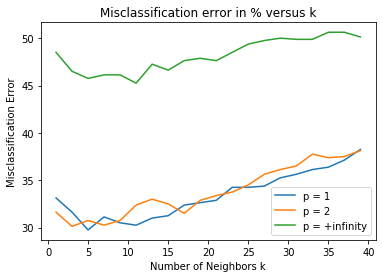

In [46]:
cv_results = grid_search_knn.cv_results_
mse = defaultdict(list)
for i, estimator in enumerate(cv_results["estimators"]):
    p_value = estimator.get_params()["p"]
    mse[p_value].append(100 - cv_results["scores"][i])
    
all_mse = [100 - x for x in cv_results["scores"]]


plt.plot(n_neighbors, mse[1], label="p = 1")
plt.plot(n_neighbors, mse[2], label="p = 2")
plt.plot(n_neighbors, mse["+infty"], label="p = +infinity")
plt.title("Misclassification error in % versus k")
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.legend()
plt.savefig("Models/knn_misclassification_error.png")
plt.show()
plt.close()

In [47]:
#optimal_k = cv_results.neighbors[optimal_index]
#print("The optimal number of neighbors is {}".format(optimal_k))

print("La meilleure combinaison d'hyperparametres avec grid search cv est :\n", grid_search_knn.best_params_)
print("")
print("Le score moyen du modele avec ces hyperparametres est :\n %.2f"%grid_search_knn.best_score_)

La meilleure combinaison d'hyperparametres avec grid search cv est :
 {'n_neighbors': 5, 'metric': <function minkowski at 0x000001BB2556C798>, 'p': 1}

Le score moyen du modele avec ces hyperparametres est :
 70.25


### 4.2 Autres distances 

In [48]:
cv_results_SquD = {
    "estimators" : [],
    "scores": [],
}

for k in n_neighbors:
    model = knn.KNeighborsClassifier(n_neighbors=k, metric=knn.SquD)
    score = pt.kFoldCV(model, data_train, label_train, 5)
    cv_results_SquD["estimators"].append(model)
    cv_results_SquD["scores"].append(score)

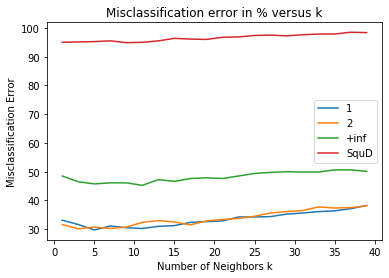

In [49]:
mse_SquD = [100 - x for x in cv_results_SquD["scores"]]

plt.plot(n_neighbors, mse[1], label="1")
plt.plot(n_neighbors, mse[2], label="2")
plt.plot(n_neighbors, mse["+infty"], label="+inf")
plt.plot(n_neighbors, mse_SquD, label="SquD")
plt.title("Misclassification error in % versus k")
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.legend()
plt.savefig("Models/knn_all_misclassification_error.png")
plt.show()
plt.close()

In [50]:
#best_knn_SquD = cv_results["estimators"][optimal_index]

On sauvegarde le meilleur modèle.

In [51]:
best_knn = grid_search_knn.best_estimator_
print(best_knn.get_params())

{'n_neighbors': 5, 'metric': <function minkowski at 0x000001BB2556C798>, 'p': 1}


In [58]:
best_knn = knn.KNeighborsClassifier(n_neighbors=5, p=1)
base_model = knn.KNeighborsClassifier()

In [59]:
print(best_knn.get_params())
print(base_model.get_params())

{'n_neighbors': 5, 'metric': <function minkowski at 0x000001BB2556C798>, 'p': 1}
{'n_neighbors': 1, 'metric': <function minkowski at 0x000001BB2556C798>, 'p': 2}


In [60]:
best_knn.fit(data_train, label_train)
base_model.fit(data_train, label_train)
# Test de validation
best_knn_predictions = best_knn.predict(data_test)
base_model_predictions = base_model.predict(data_test)

Voyons si le réglage des hyper-paramètres a permis d'obtenir un meilleur modèle.

Je ne comprends pas, le graphique montre pourtant l'inverse

In [65]:
best_knn.score_ = base_model.score(best_knn_predictions, label_test) * 100
print("Base model score: {} %".format(base_model.score(base_model_predictions, label_test) * 100))
print("Best model score: {} %".format(best_knn.score_))

Base model score: 67.5 %
Best model score: 66.5 %


Sauvegardons le score du modèle pour pouvoir le comparer aux autres modèles.

In [66]:
d = {
    'Model': 'K Nearest Neighbors',
    'Test Set Accuracy': best_knn.score_
}

df_models_knn = pd.DataFrame(d, index=[0])

In [67]:
with open('Models/best_knn.pickle', 'wb') as output:
    pickle.dump(best_knn, output)

with open('Models/df_models_knn.pickle', 'wb') as output:
    pickle.dump(df_models_knn, output)